In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset_mood_smartphone.csv')  # replace with the actual dataset path


In [3]:
#CLEANING DATA
import pandas as pd

# 1. Define expected ranges for each variable.
#    Format: variable_name: (min_value, max_value)
expected_ranges = {
    'mood': (1, 10),
    'circumplex.valence': (-2, 2),
    'circumplex.arousal': (-2, 2),
    'activity': (0, 1),
    # If you have more variables, add them here:
    # 'screen': (0, 1440),  # e.g., if screen usage is in minutes
    # 'appCat.social': (0, 1440), 
    # 'call': (0, 1),       # if call is an indicator
    # 'sms': (0, 1),
    # etc.
}

# 2. For each variable in expected_ranges, find rows that are out of range
outliers_list = []  # to store all out-of-range rows

for var_name, (min_val, max_val) in expected_ranges.items():
    # Filter dataset rows that match this variable
    mask_var = (df['variable'] == var_name)
    
    # Among these rows, find those whose value is < min_val or > max_val
    mask_outlier = (df['value'] < min_val) | (df['value'] > max_val)
    
    # Combine the two masks to find out-of-range rows for this variable
    outliers = df[mask_var & mask_outlier]
    
    if not outliers.empty:
        print(f"Variable '{var_name}': Found {len(outliers)} out-of-range rows.")
        outliers_list.append(outliers)

# 3. Combine all out-of-range rows (if you want a single dataframe of outliers)
if outliers_list:
    df_outliers = pd.concat(outliers_list, ignore_index=True)
    print("\nSummary of out-of-range rows:")
    print(df_outliers.head())
else:
    print("No out-of-range values found based on the defined expected ranges.")

Variable 'mood': Found 1 out-of-range rows.

Summary of out-of-range rows:
   Unnamed: 0       id                     time variable  value
0        1367  AS14.08  2014-03-31 12:00:00.000     mood   75.0


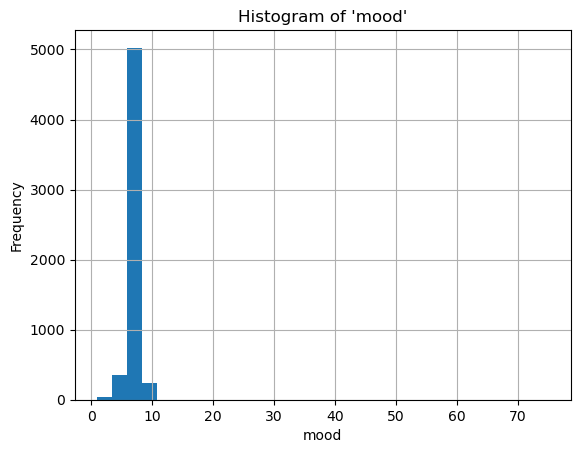

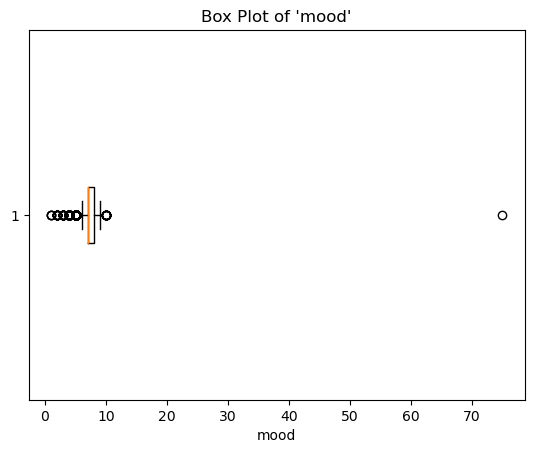

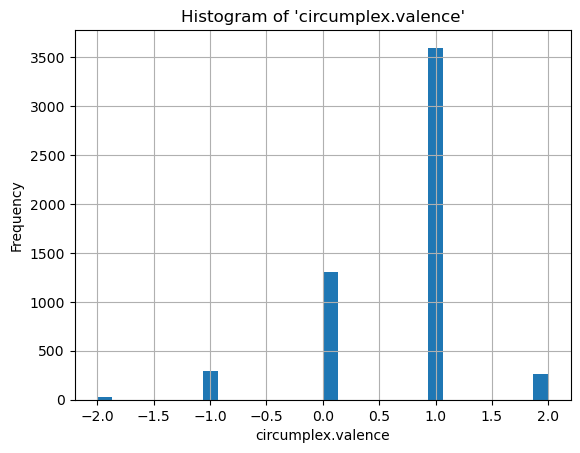

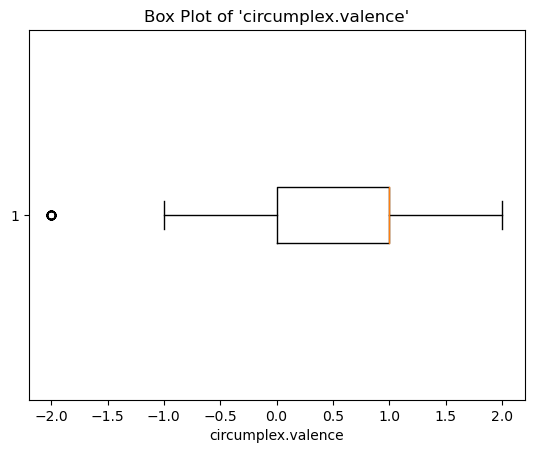

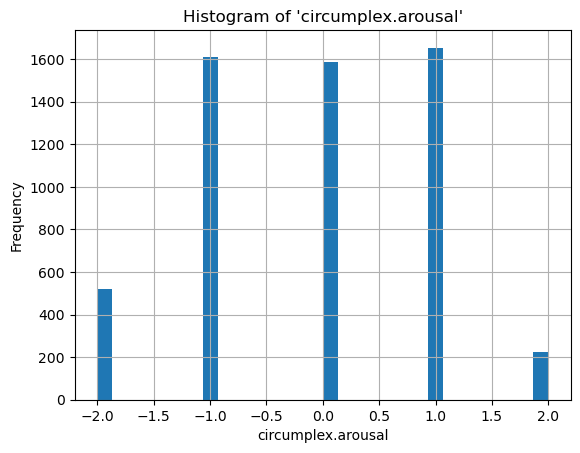

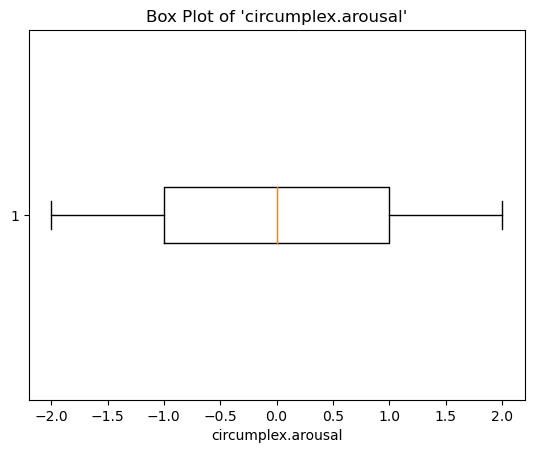

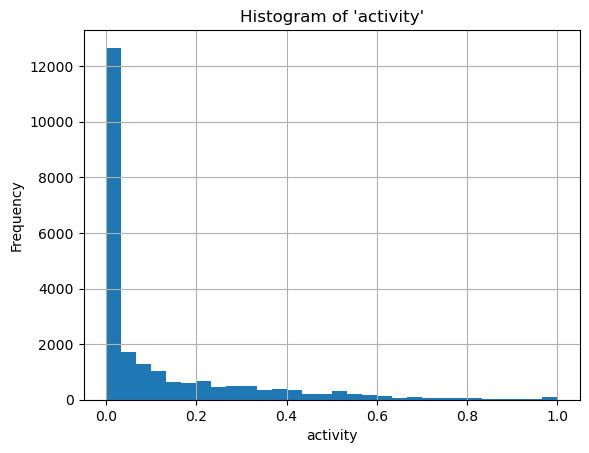

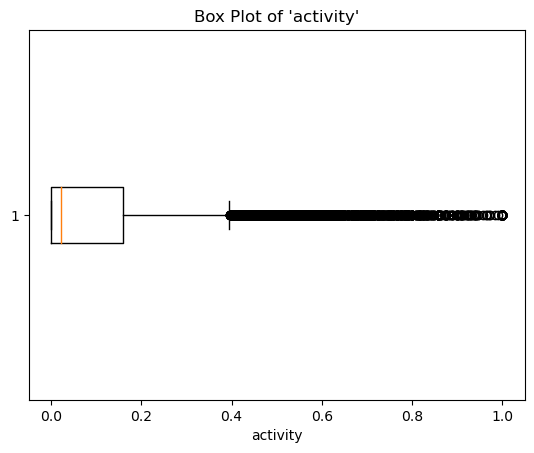

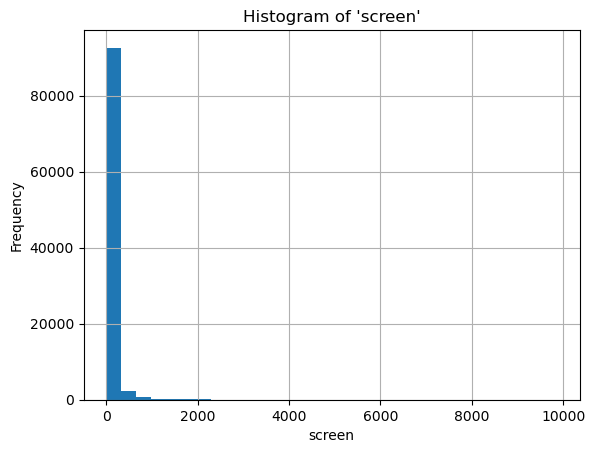

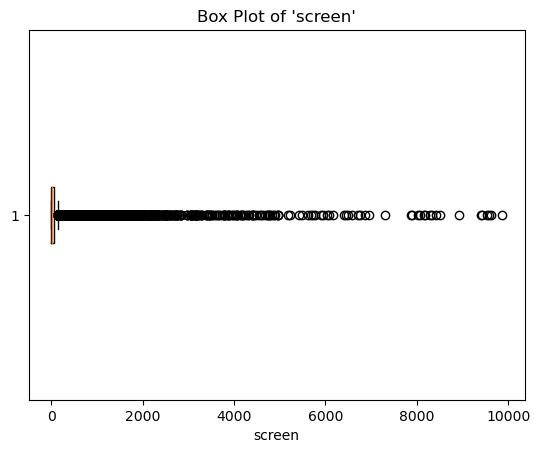

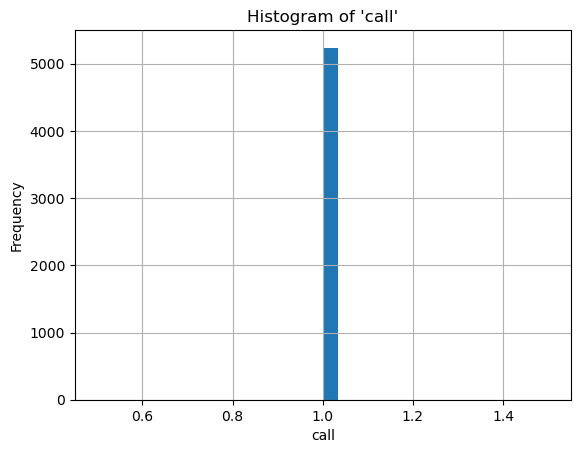

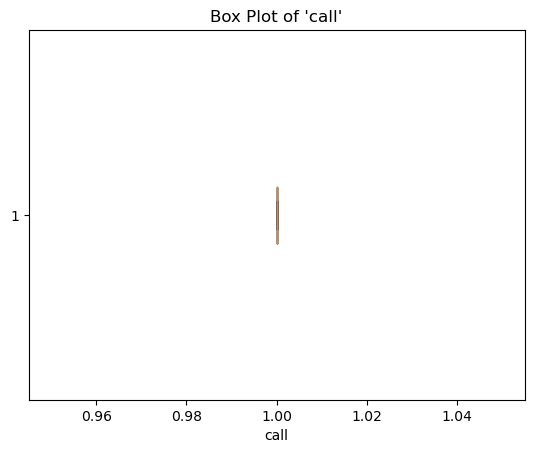

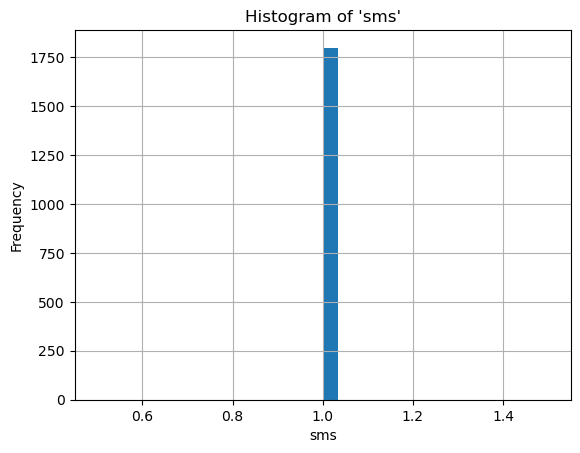

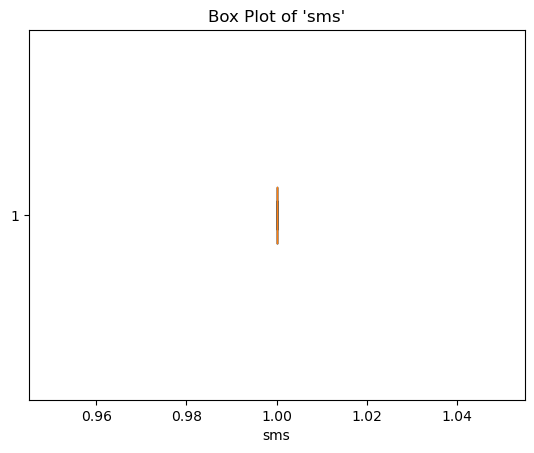

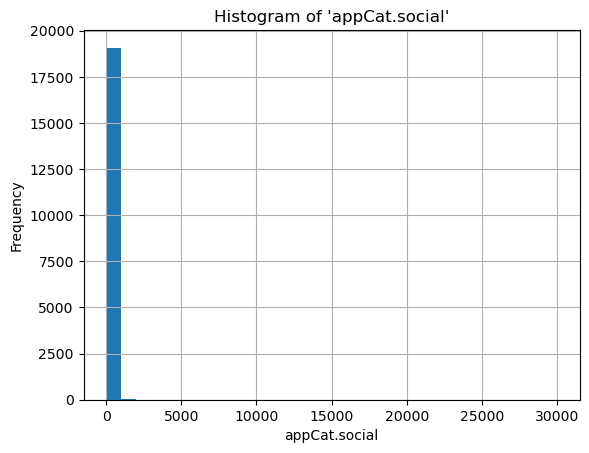

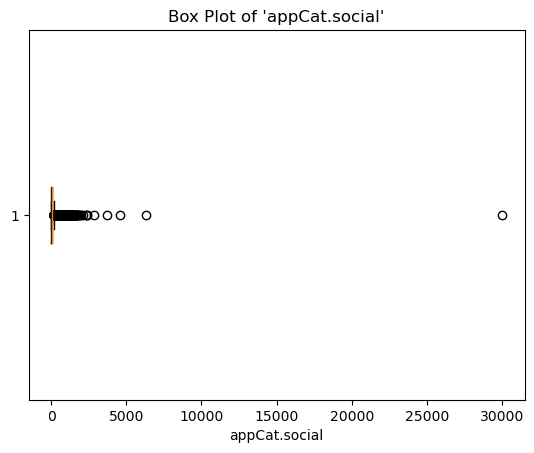

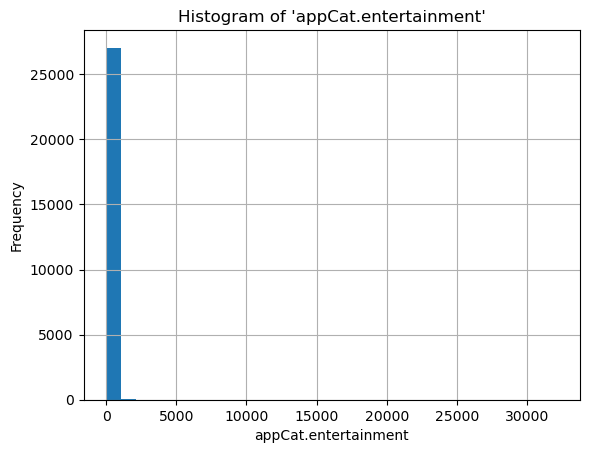

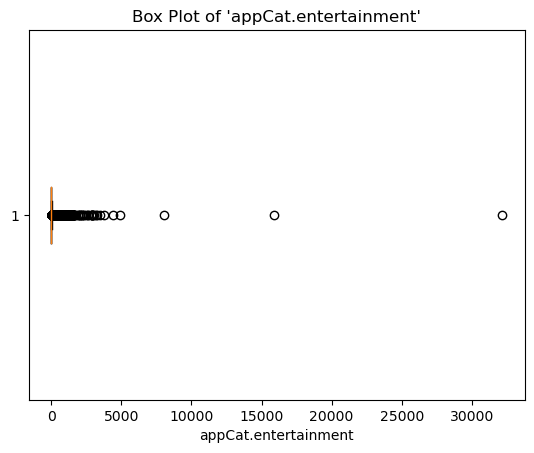

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define which variables you want to visualize
#    (Adjust this list to match the variables actually in your dataset)
variables_of_interest = [
    'mood',
    'circumplex.valence',
    'circumplex.arousal',
    'activity',
    'screen',
    'call',
    'sms',
    'appCat.social',
    'appCat.entertainment'
]

# 2. Loop over each variable and plot a histogram
for var_name in variables_of_interest:
    # Filter to rows for this variable
    df_var = df[df['variable'] == var_name]

    # Skip if empty
    if df_var.empty:
        print(f"No rows found for variable '{var_name}'. Skipping...")
        continue

    # Convert to numeric if necessary
    values = pd.to_numeric(df_var['value'], errors='coerce').dropna()

    # Plot histogram
    plt.figure()
    values.hist(bins=30)  # 30 bins is arbitrary; adjust as needed
    plt.title(f"Histogram of '{var_name}'")
    plt.xlabel(var_name)
    plt.ylabel("Frequency")
    plt.show()

    # (Optional) Also plot a box plot to see outliers/percentiles
    plt.figure()
    plt.boxplot(values, vert=False)
    plt.title(f"Box Plot of '{var_name}'")
    plt.xlabel(var_name)
    plt.show()

In [5]:
import pandas as pd
import numpy as np

# -------------------------------------------------------
# 1) Load Dataset
# -------------------------------------------------------
df = pd.read_csv('cleaned_long_format.csv')  # Change path if needed

# -------------------------------------------------------
# 2) Convert 'time' & Extract Date, Weekday
# -------------------------------------------------------
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['date'] = df['time'].dt.date
df['weekday'] = df['time'].dt.dayofweek   # Monday=0, Sunday=6

# Optional: if you want weekday names:
# df['weekday_name'] = df['time'].dt.day_name()

df['entry_count'] = 1  # helper for counting total rows per (id, date)

# -------------------------------------------------------
# 3) Define Variables to Sum
# -------------------------------------------------------
# We definitely want 'call' and 'sms' included, to ensure they appear in the final daily DataFrame.
variables_to_sum = [
    'mood',
    'activity',
    'circumplex.arousal',
    'circumplex.valence',
    'screen',
    'call',
    'sms',
    'appCat.builtin',
    'appCat.communication',
    'appCat.entertainment',
    'appCat.finance',
    'appCat.game',
    'appCat.office',
    'appCat.other',
    'appCat.social',
    'appCat.travel',
    'appCat.unknown',
    'appCat.utilities',
    'appCat.weather',
]

df_sum = df[df['variable'].isin(variables_to_sum)].copy()

# -------------------------------------------------------
# 4) Group by (id, date, variable) => sum(value), then unstack
# -------------------------------------------------------
df_sum_grouped = (
    df_sum
    .groupby(['id', 'date', 'variable'])['value']
    .sum()                # sum of 'value' for each variable that day
    .unstack(fill_value=0)# columns become each variable; missing => 0
    .reset_index()        # bring 'id' and 'date' back as columns
)

# (Now df_sum_grouped has columns: ['id','date', 'mood','call','sms', 'screen', etc.]
#  If the dataset doesn't contain any rows for 'call' or 'sms', those columns
#  might not appear automatically. We'll fix that next.)

# Ensure each variable in variables_to_sum is present as a column, set to 0 if missing.
all_cols = ['id','date'] + variables_to_sum  # the columns we want
current_cols = df_sum_grouped.columns.tolist()
missing_cols = [col for col in all_cols if col not in current_cols]

for col in missing_cols:
    df_sum_grouped[col] = 0  # create missing columns with default=0

# Reorder columns so they're in a consistent order
df_sum_grouped = df_sum_grouped[all_cols]

# -------------------------------------------------------
# 5) Aggregate Mood Stats Separately (avg, var, count)
# -------------------------------------------------------
df_mood = df[df['variable'] == 'mood'].copy()
df_mood_grouped = (
    df_mood
    .groupby(['id','date'])['value']
    .agg(mood_avg='mean', mood_var='var', mood_count='count')
    .reset_index()
)

# -------------------------------------------------------
# 6) total_entries per (id, date)
# -------------------------------------------------------
df_entries = (
    df
    .groupby(['id','date'])['entry_count']
    .sum()
    .reset_index(name='total_entries')
)

# -------------------------------------------------------
# 7) Merge Summations + Mood Stats + total_entries
# -------------------------------------------------------
daily_merged = pd.merge(df_sum_grouped, df_mood_grouped, on=['id','date'], how='outer')
daily_merged = pd.merge(daily_merged, df_entries, on=['id','date'], how='outer')

# Merge weekday info
df_weekday = df[['id','date','weekday']].drop_duplicates()
daily_merged = pd.merge(daily_merged, df_weekday, on=['id','date'], how='left')

# -------------------------------------------------------
# 8) Remove rows if:
#    A) total_entries == 0 (no data at all)
#    B) only call/sms => call+sms == total_entries
# -------------------------------------------------------
condition_remove = (
    (daily_merged['total_entries'] == 0) |
    ((daily_merged['call'] + daily_merged['sms']) == daily_merged['total_entries'])
)
daily_cleaned = daily_merged[~condition_remove].copy()

# -------------------------------------------------------
# 9) Final Check
# -------------------------------------------------------
print("daily_merged columns:", daily_merged.columns)
print("Original daily_merged shape:", daily_merged.shape)
print("After removal shape:", daily_cleaned.shape)
print(daily_cleaned.head(100))

daily_cleaned.to_csv('daily_cleaned.csv', index=False)


daily_merged columns: Index(['id', 'date', 'mood', 'activity', 'circumplex.arousal',
       'circumplex.valence', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'mood_avg', 'mood_var', 'mood_count', 'total_entries', 'weekday'],
      dtype='object')
Original daily_merged shape: (1973, 26)
After removal shape: (1309, 26)
          id        date  mood  activity  circumplex.arousal  \
7    AS14.01  2014-02-26  25.0  0.000000                -1.0   
8    AS14.01  2014-02-27  19.0  0.000000                 0.0   
25   AS14.01  2014-03-20   0.0  0.163095                 0.0   
26   AS14.01  2014-03-21  31.0  3.083152                 1.0   
27   AS14.01  2014-03-22  32.0  3.790084                 3.0   
..       ...         ...   ...       ...                 ...   
17

____________________________________________________Populating missing mood values____________________________________________________

In [6]:

# Count the rows where 'mood_avg' is missing (NaN)
missing_mood_avg_count = daily_cleaned['mood_avg'].isna().sum()
print(f"Number of rows where 'mood_avg' is missing: {missing_mood_avg_count}")

# Display all rows where 'mood_avg' is missing
missing_mood_avg_rows = daily_cleaned[daily_cleaned['mood_avg'].isna()]
print(missing_mood_avg_rows.to_string())

Number of rows where 'mood_avg' is missing: 41
           id        date  mood  activity  circumplex.arousal  circumplex.valence        screen  call  sms  appCat.builtin  appCat.communication  appCat.entertainment  appCat.finance  appCat.game  appCat.office  appCat.other  appCat.social  appCat.travel  appCat.unknown  appCat.utilities  appCat.weather  mood_avg  mood_var  mood_count  total_entries  weekday
25    AS14.01  2014-03-20   0.0  0.163095                 0.0                 0.0   2275.944000   1.0  0.0         248.979              2168.229               350.856           0.000        0.000          0.000        11.345        807.731          0.000          45.173            21.074           0.000       NaN       NaN         NaN            113        3
71    AS14.01  2014-05-05   0.0  0.086269                 0.0                 0.0   1788.734000   0.0  0.0         438.347               826.787               318.514           0.000        0.000          0.000         0.000       

In [7]:
# this fills data only per user
# For each user (id), fill missing mood_avg values using forward fill
daily_cleaned['mood_avg_filled'] = daily_cleaned.groupby('id')['mood_avg'].fillna(method='ffill')

# Optionally, if some values at the beginning remain missing, apply a backward fill as well:
daily_cleaned['mood_avg_filled'] = daily_cleaned.groupby('id')['mood_avg_filled'].fillna(method='bfill')

print(daily_cleaned[['id', 'date', 'mood_avg', 'mood_avg_filled']].head(20))


         id        date  mood_avg  mood_avg_filled
7   AS14.01  2014-02-26  6.250000         6.250000
8   AS14.01  2014-02-27  6.333333         6.333333
25  AS14.01  2014-03-20       NaN         6.333333
26  AS14.01  2014-03-21  6.200000         6.200000
27  AS14.01  2014-03-22  6.400000         6.400000
28  AS14.01  2014-03-23  6.800000         6.800000
29  AS14.01  2014-03-24  6.000000         6.000000
30  AS14.01  2014-03-25  6.750000         6.750000
31  AS14.01  2014-03-26  6.600000         6.600000
32  AS14.01  2014-03-27  7.000000         7.000000
33  AS14.01  2014-03-28  6.400000         6.400000
34  AS14.01  2014-03-29  8.000000         8.000000
35  AS14.01  2014-03-30  7.500000         7.500000
36  AS14.01  2014-03-31  7.400000         7.400000
37  AS14.01  2014-04-01  6.000000         6.000000
38  AS14.01  2014-04-02  6.500000         6.500000
39  AS14.01  2014-04-03  6.400000         6.400000
40  AS14.01  2014-04-04  6.200000         6.200000
41  AS14.01  2014-04-05  6.8000